In [22]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
import time
import random
from tqdm import tqdm_notebook

# Fastai
from fastai import *
from fastai.tabular import *

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import seaborn as sns
import time
import matplotlib.pyplot as plt
%matplotlib inline
# Any results you write to the current directory are saved as output.

## Vectorized PDF calculation to get correlation matrix. Study of Feature Grouping

In [3]:
def logloss(y,yp):
    yp = np.clip(yp,1e-5,1-1e-5)
    return -y*np.log(yp)-(1-y)*np.log(1-yp)
    
def reverse(tr,te):
    reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
                22,24,25,26,27,41,29,
                32,35,37,40,48,49,47,
                55,51,52,53,60,61,62,103,65,66,67,69,
                70,71,74,78,79,
                82,84,89,90,91,94,95,96,97,99,
                105,106,110,111,112,118,119,125,128,
                130,133,134,135,137,138,
                140,144,145,147,151,155,157,159,
                161,162,163,164,167,168,
                170,171,173,175,176,179,
                180,181,184,185,187,189,
                190,191,195,196,199]
    reverse_list = ['var_%d'%i for i in reverse_list]
    for col in reverse_list:
        tr[col] = tr[col]*(-1)
        te[col] = te[col]*(-1)
    return tr,te

def scale(tr,te):
    for col in tr.columns:
        if col.startswith('var_'):
            mean,std = tr[col].mean(),tr[col].std()
            tr[col] = (tr[col]-mean)/std
            te[col] = (te[col]-mean)/std
    return tr,te

def getp_vec_sum(x,x_sort,y,std,c=0.5):
    # x is sorted
    left = x - std/c
    right = x + std/c
    p_left = np.searchsorted(x_sort,left)
    p_right = np.searchsorted(x_sort,right)
    p_right[p_right>=y.shape[0]] = y.shape[0]-1
    p_left[p_left>=y.shape[0]] = y.shape[0]-1
    return (y[p_right]-y[p_left])

def get_pdf(tr,col,x_query=None,smooth=3):
    std = tr[col].std()
    df = tr.groupby(col).agg({'target':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index()
    df = df.sort_values(col)
    y,c = cols
    
    df[y] = df[y].cumsum()
    df[c] = df[c].cumsum()
    
    if x_query is None:
        rmin,rmax,res = -5.0, 5.0, 501
        x_query = np.linspace(rmin,rmax,res)
    
    dg = pd.DataFrame()
    tm = getp_vec_sum(x_query,df[col].values,df[y].values,std,c=smooth)
    cm = getp_vec_sum(x_query,df[col].values,df[c].values,std,c=smooth)+1
    dg['res'] = tm/cm
    dg.loc[cm<500,'res'] = 0.1
    return dg['res'].values

def get_pdfs(tr):
    y = []
    for i in range(200):
        name = 'var_%d'%i
        res = get_pdf(tr,name)
        y.append(res)
    return np.vstack(y)

def print_corr(corr_mat,col,bar=0.97):
    print(col)
    cols = corr_mat.loc[corr_mat[col]>bar,col].index.values
    cols_ = ['var_%s'%(i.split('_')[-1]) for i in cols]
    print(cols)
    return cols

In [4]:
%%time
path = '/storage/santander_comp/'
tr = pd.read_csv('%s/train.csv'%path)
te = pd.read_csv('%s/test.csv'%path)

CPU times: user 13.6 s, sys: 1.02 s, total: 14.7 s
Wall time: 14.7 s


In [5]:
%%time
tr,te = reverse(tr,te)
tr,te = scale(tr,te)

CPU times: user 1.84 s, sys: 124 ms, total: 1.96 s
Wall time: 1.52 s


CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 90.9 ms


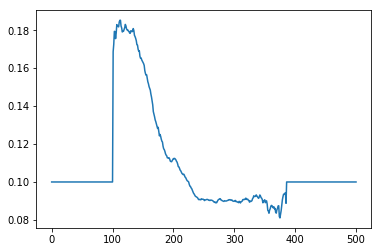

In [6]:
%%time
prob = get_pdf(tr,'var_0')
plt.plot(prob)

In [7]:
%%time
pdfs = get_pdfs(tr)

CPU times: user 30.1 s, sys: 40.9 s, total: 1min 11s
Wall time: 14.7 s


In [8]:
%%time
df_pdf = pd.DataFrame(pdfs.T,columns=['var_prob_%d'%i for i in range(200)])
corr_mat = df_pdf.corr(method='pearson')

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 37.3 ms


In [54]:
corr_mat.shape

(200, 200)

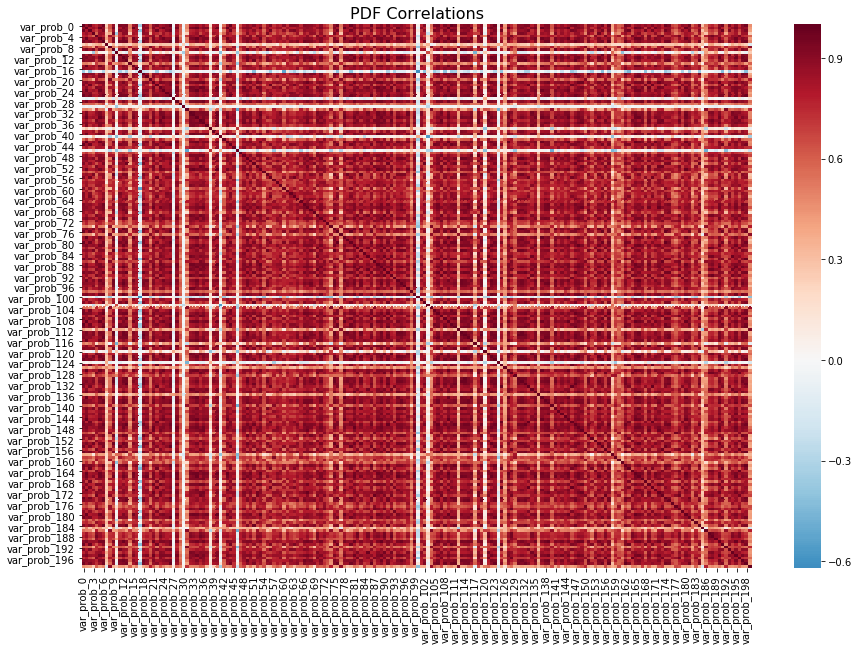

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_mat, cmap='RdBu_r', center = 0.0)
plt.title('PDF Correlations', fontsize = 16)
plt.show()

### Group features using this correlation matrix. 

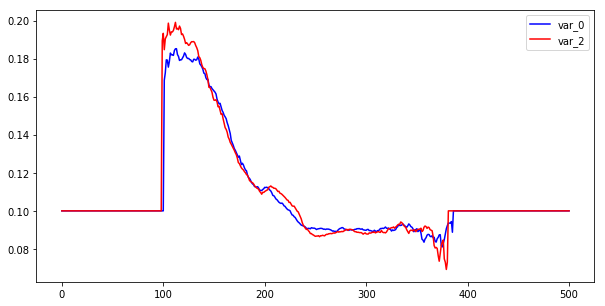

In [12]:
plt.figure(figsize=(10,5))
plt.plot(pdfs[0], color='b', label = 'var_0')
plt.plot(pdfs[2], color='r', label = 'var_2')
plt.legend(loc='upper right')

In [52]:
no_corr = corr_mat.loc[corr_mat.mean(axis=0) < 0.15]

In [53]:
no_corr

,var_prob_0,var_prob_1,var_prob_2,var_prob_3,var_prob_4,var_prob_5,var_prob_6,var_prob_7,var_prob_8,var_prob_9,...,var_prob_190,var_prob_191,var_prob_192,var_prob_193,var_prob_194,var_prob_195,var_prob_196,var_prob_197,var_prob_198,var_prob_199
var_prob_10,0.032000,0.023516,0.025634,-0.342803,0.342608,0.069668,0.026844,0.022297,0.351059,-0.153350,...,0.047652,-0.051062,0.354223,0.133424,0.072009,0.138508,0.230151,0.042490,-0.076510,0.254039
var_prob_17,-0.346605,-0.037313,-0.387666,-0.121922,-0.037214,-0.054294,-0.287449,0.164173,0.073201,-0.098891,...,-0.109931,-0.419208,0.032268,-0.319979,0.007959,-0.110486,0.015007,-0.168756,-0.413805,0.112952
var_prob_27,-0.021848,-0.081408,-0.056041,-0.100831,0.191631,-0.035868,-0.056989,0.099135,0.146142,-0.147826,...,-0.017324,-0.041897,0.045505,-0.051886,-0.061735,-0.030508,0.109651,-0.069994,0.003921,0.118930
var_prob_30,-0.044459,-0.015913,-0.075044,0.073114,-0.060210,-0.025786,-0.049735,0.242681,0.078874,0.017247,...,-0.035014,-0.030585,-0.045836,-0.066198,0.003481,-0.077159,-0.047980,-0.029794,-0.019941,0.082290
var_prob_38,0.153137,0.273645,0.150499,0.229324,0.106427,0.246586,0.161561,0.054280,-0.042409,0.201963,...,0.128487,0.145099,-0.180972,0.019898,0.215388,0.137297,0.095218,0.134547,0.172285,-0.056005
var_prob_41,0.026666,0.082804,0.023670,0.279090,0.016113,0.061478,0.021105,0.003849,-0.297495,0.030423,...,0.072438,0.067400,-0.177268,-0.060442,0.121477,0.041366,-0.091536,-0.027002,0.128024,-0.332357
var_prob_46,0.021285,0.054102,0.033452,0.234131,-0.122656,0.032096,0.020981,-0.057726,-0.259975,0.098630,...,-0.027468,0.064594,-0.412288,-0.140905,0.004833,-0.051559,-0.089118,-0.018517,0.091610,-0.213560
var_prob_100,0.057533,-0.078717,0.118199,0.028346,-0.230606,-0.090441,0.032469,-0.137474,-0.372041,-0.055709,...,-0.084994,0.159932,-0.281842,0.086786,-0.219655,-0.078790,-0.381126,0.016750,0.126502,-0.406828
var_prob_103,0.032185,0.104218,0.038713,-0.219783,0.224332,0.143211,0.016744,0.336604,0.204867,-0.008996,...,0.045626,-0.046595,0.183023,0.107926,0.123268,0.138649,0.234068,0.056408,-0.069599,0.049455
var_prob_124,0.059926,0.008084,0.082324,-0.007281,-0.026167,0.035668,-0.044437,0.364451,-0.100655,0.008589,...,-0.099841,0.083125,-0.315256,-0.121339,-0.029100,-0.105726,0.019599,-0.044101,0.008822,-0.162473


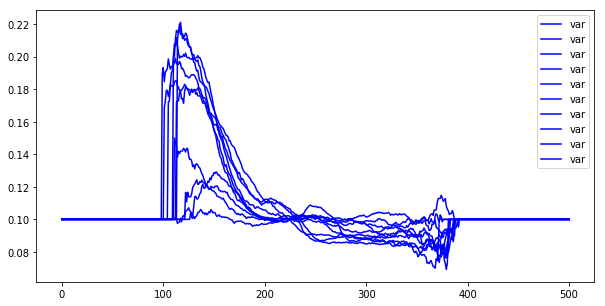

In [43]:
plt.figure(figsize=(10,5))
for i in range(len(no_corr)):
    plt.plot(pdfs[i], color='b', label = ('var'))
plt.legend(loc='upper right')

In [13]:
cols = print_corr(corr_mat, 'var_prob_12')
corr_mat.loc[cols, cols]

var_prob_12
['var_prob_12' 'var_prob_75' 'var_prob_81' 'var_prob_83' 'var_prob_89'
 'var_prob_95' 'var_prob_99' 'var_prob_113' 'var_prob_122' 'var_prob_139'
 'var_prob_154' 'var_prob_190']


,var_prob_12,var_prob_75,var_prob_81,var_prob_83,var_prob_89,var_prob_95,var_prob_99,var_prob_113,var_prob_122,var_prob_139,var_prob_154,var_prob_190
var_prob_12,1.000000,0.986023,0.974172,0.973832,0.986651,0.982335,0.995830,0.973779,0.977389,0.976521,0.971197,0.980504
var_prob_75,0.986023,1.000000,0.956044,0.988545,0.961934,0.968621,0.981870,0.979612,0.976348,0.951480,0.982545,0.956346
var_prob_81,0.974172,0.956044,1.000000,0.924456,0.972034,0.959667,0.973291,0.938961,0.975986,0.972479,0.967149,0.976072
var_prob_83,0.973832,0.988545,0.924456,1.000000,0.943665,0.957289,0.967895,0.977109,0.959866,0.931672,0.968721,0.933680
var_prob_89,0.986651,0.961934,0.972034,0.943665,1.000000,0.971942,0.989338,0.961916,0.974068,0.978463,0.954030,0.988728
var_prob_95,0.982335,0.968621,0.959667,0.957289,0.971942,1.000000,0.980663,0.961202,0.954215,0.972086,0.949408,0.968666
var_prob_99,0.995830,0.981870,0.973291,0.967895,0.989338,0.980663,1.000000,0.970514,0.979408,0.981130,0.969094,0.986252
var_prob_113,0.973779,0.979612,0.938961,0.977109,0.961916,0.961202,0.970514,1.000000,0.967848,0.938063,0.969930,0.948541
var_prob_122,0.977389,0.976348,0.975986,0.959866,0.974068,0.954215,0.979408,0.967848,1.000000,0.957901,0.990639,0.970853
var_prob_139,0.976521,0.951480,0.972479,0.931672,0.978463,0.972086,0.981130,0.938063,0.957901,1.000000,0.941614,0.983958


## Correlations

In [14]:
df_corr = tr.corr(method='spearman').abs()

In [15]:
df_corr = df_corr.sort_values('target', axis=0, ascending=False).sort_values('target', axis=1, ascending=False)

In [16]:
df_corr.shape

(201, 201)

In [18]:
df_corr.tail()

,target,var_81,var_139,var_6,var_12,var_110,var_146,var_76,var_53,var_21,...,var_10,var_100,var_126,var_103,var_41,var_17,var_38,var_30,var_27,var_185
var_17,0.001071,0.002410,0.000102,0.000252,0.002594,0.001056,0.000759,0.001670,0.001687,0.000572,...,0.004701,0.000573,0.002275,0.000479,0.002073,1.000000,0.002681,0.003337,0.001906,0.001452
var_38,0.000977,0.002188,0.003479,0.003859,0.002579,0.004725,0.001870,0.000375,0.000933,0.003793,...,0.000260,0.002869,0.002482,0.001102,0.001237,0.002681,1.000000,0.001498,0.000187,0.001989
var_30,0.000774,0.000470,0.001546,0.000823,0.000706,0.003353,0.001200,0.000264,0.004653,0.004080,...,0.001748,0.000784,0.001647,0.001599,0.000790,0.003337,0.001498,1.000000,0.003209,0.001165
var_27,0.000461,0.002237,0.001597,0.002087,0.001045,0.001495,0.001299,0.001030,0.000058,0.002839,...,0.000578,0.004054,0.001502,0.001296,0.004977,0.001906,0.000187,0.003209,1.000000,0.003659
var_185,0.000159,0.001139,0.001194,0.001025,0.000067,0.001393,0.001538,0.000086,0.000196,0.000559,...,0.002303,0.000679,0.000159,0.003343,0.001335,0.001452,0.001989,0.001165,0.003659,1.000000


In [21]:
tr.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,0.577100,1.273734,-0.451706,0.833707,-0.235571,0.536429,0.334925,-0.608749,...,-0.263373,1.149155,0.817467,-0.411012,0.168704,1.578113,-1.022128,-0.373967,-1.026395,-0.214134
1,train_1,0,-0.269958,0.622136,-1.190357,0.688845,-0.790973,-1.539897,-0.244461,0.003525,...,-0.966609,-0.093604,0.443622,1.908760,-0.817592,-1.522338,-1.067651,-0.129399,0.825415,-0.505684
2,train_2,0,0.681112,0.276066,-0.516987,-0.536515,0.305476,0.511032,-1.769834,0.564748,...,0.072093,-0.777995,-0.174130,-0.412315,1.151588,-2.297364,1.617902,-0.695139,-0.381448,-0.356681
3,train_3,0,-0.125158,0.129425,0.667574,-0.195354,-0.927990,-0.410671,-0.500632,0.474200,...,-0.270215,0.891454,-0.818466,-0.478547,1.607865,0.789515,0.959017,1.501741,0.697116,0.543500
4,train_4,0,0.277303,-0.035610,-0.817681,0.077829,-0.738605,-0.955572,-0.613370,-0.791542,...,1.036189,-0.688986,-1.405984,1.468532,-1.501098,0.958471,-0.297626,0.645536,0.706316,0.525374


In [26]:
X = tr.copy()
y = X['target']
X.drop(['ID_code', 'target'], axis = 1, inplace = True)

In [28]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [29]:
te.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,-0.126868,-2.322795,-0.847595,-1.288429,-0.218320,-0.341438,-0.508133,-0.503690,-0.554978,...,1.182047,-1.459046,-2.271230,-0.220683,-1.365985,-1.825269,-0.378057,1.965920,-0.132357,0.516685
1,test_1,0.707065,-0.711578,-0.223223,0.788291,1.158817,-0.133992,-0.704646,-0.610212,1.409474,...,-1.618901,-0.461914,-0.667968,1.702499,-0.771024,-0.433329,0.694587,1.045156,1.082245,1.690883
2,test_2,1.709581,2.155650,0.217537,-0.123021,0.502439,-1.891137,0.593058,-1.084777,-0.371820,...,0.873445,-1.175909,0.035485,-0.288518,-1.598796,-1.588241,1.725577,-2.003371,1.336749,1.901977
3,test_3,0.704763,-0.075412,-0.494835,0.108465,1.375433,-1.047875,0.541478,-1.176144,-0.927596,...,-1.389445,-0.541861,-0.182518,0.062506,-0.895132,-2.314085,-0.303127,0.348669,-0.947849,0.084716
4,test_4,-0.337457,-0.369112,-1.292861,-0.466922,1.216667,0.447585,-1.673828,1.738127,-0.811622,...,-0.217429,-0.573515,-0.435828,0.011530,0.497715,0.100682,1.368542,-1.757718,-0.645884,0.561224
